<img style="height:25%;weight:25%" src="https://cocstudentcouncil.github.io/assets/img/coclogo.jpg" >
<h1 style="text-align:center"> Intro to Health Analytics - Final Project </h1>
<h2>Objective:</h2>
<br>
<li>Create a neural network model which outputs a percentage likelihood the user has colorectal cancer</li>
    

<h3>Import Libraries</h3>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt

<h3>Import the Training & Testing Datasets</h3>
<br>
<i> The original image sizes are (760, 576), and due to file size constraints with Tensorflow running off of my computer's CPU instead of a dedicated GPU, they are reduced to half the size. 20% of the data is used as validation data for the model, and the seed is set at 1337 for reproducibility </i>

In [3]:
image_size = (360, 288)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "IHDA-Images",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "IHDA-Images",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1000 files belonging to 2 classes.
Using 800 files for training.
Found 1000 files belonging to 2 classes.
Using 200 files for validation.


<h3>Printing Sample Images</h3>
<br>
<i> The image labelsl are listed above each image, with a label of 1 indicating polyps are present, and 0 indicating a normal cecum scan </i>

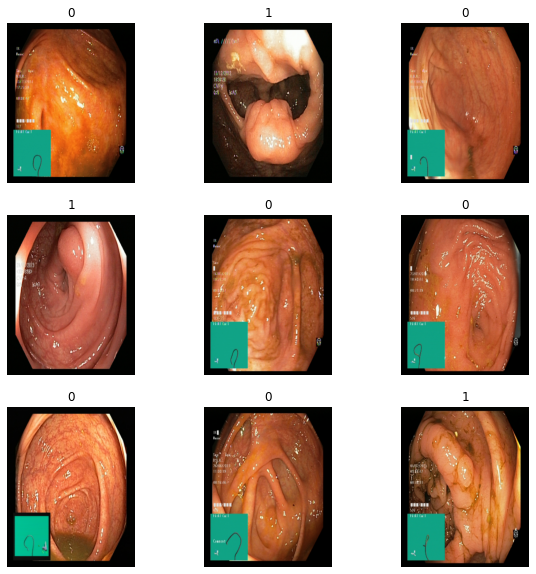

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

<h3>Creating Sample Data for the Dataset</h3>
<br>
<i> The original image are processed using a Keras model layer to randomly flip the scans on the horizontal axis, or rotate the image by 10% randomly</i>

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

<h3>Mapping the Data Augmentation Steps</h3>
<br>
<i> The original training dataset is mapped to include horizontally flipped and randomly rotated versions of the original image, to increase the amount of training data that is available, and also make the training data more diverse</i>

In [7]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [8]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

<h3>Creating the Neural Network</h3>
<br>
<i> The original images here are rescaled, converged into a 2-dimensional convolution layer, normalized, and transformed via a rectified linear activation function (ReLU) for various image sizes, and then the average result for each of the image sizes is finally placed into a Softmax function, which takes an input and normalizes the input into a probability distribution to understand what the percent likelihood that a given result belongs to the class (i.e., the image contains polyps)</i>

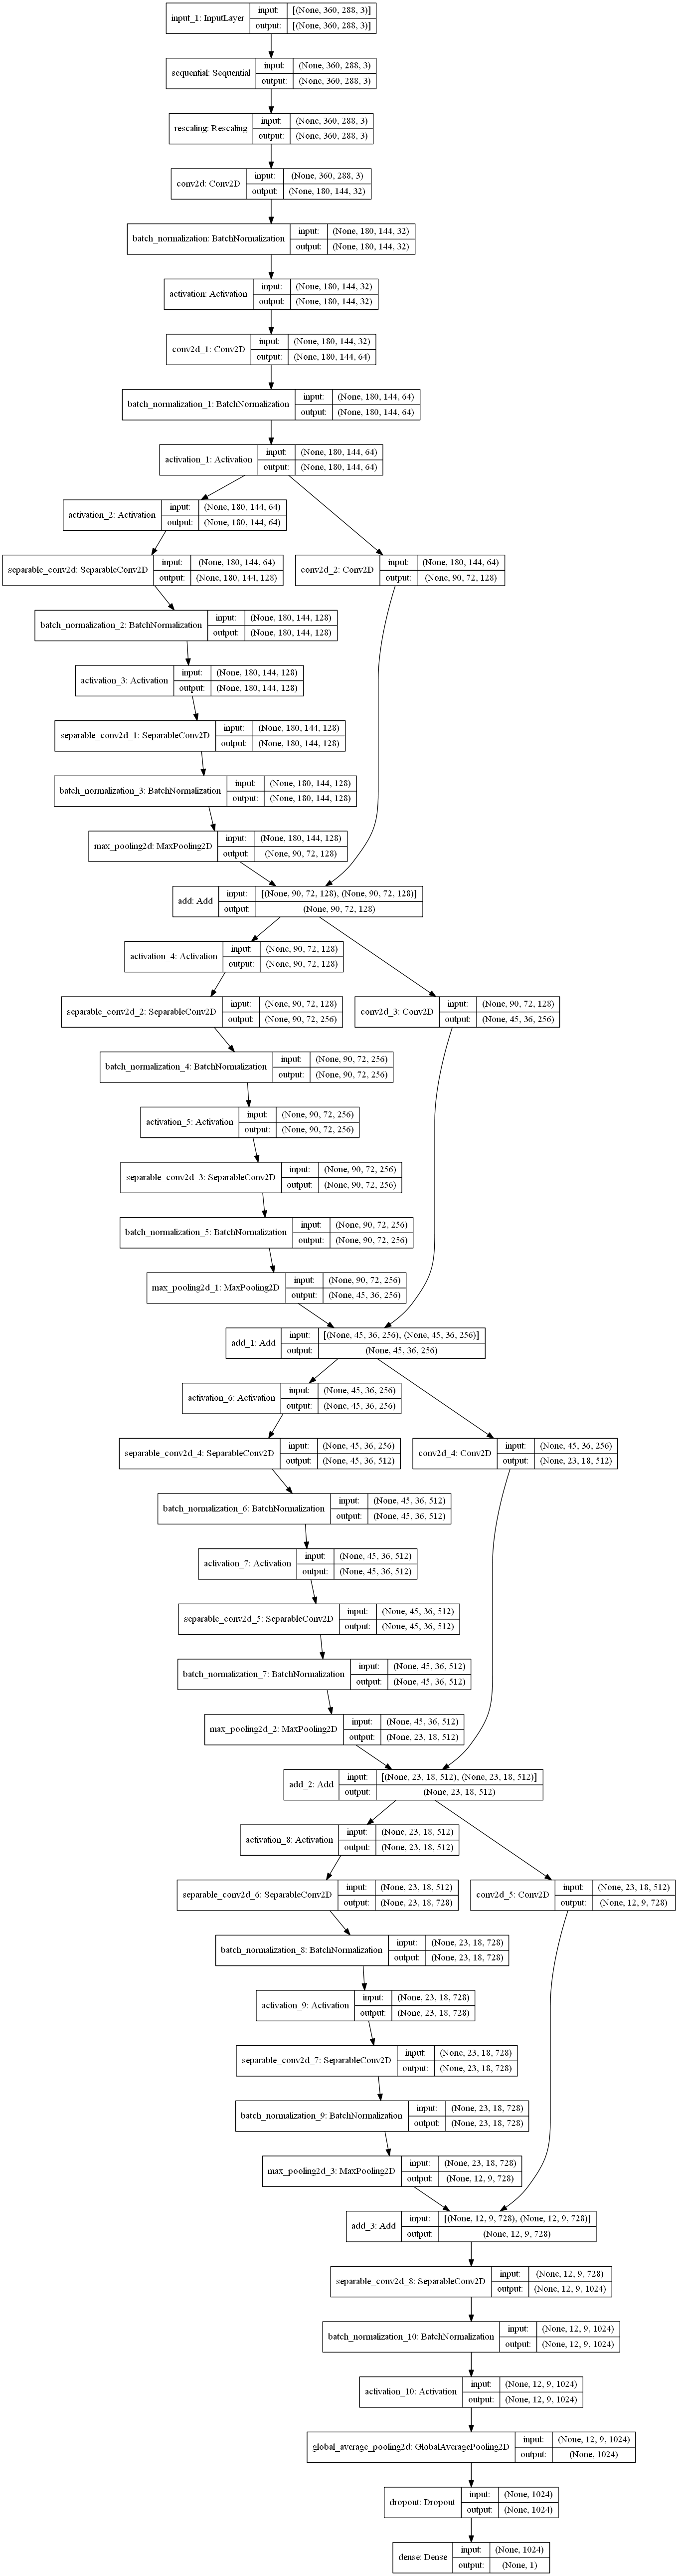

In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

<h3>Training the Neural Network</h3>
<br>
<i>To train the neural network, 50 epochs were used to capture the loss, accuracy, validation loss, and validation accuracy of each training phase. Based on the results below, epoch 49 produced the best resulting model, and thus will be the .h5 TensorFlow model that will be saved and used in the application</i>

In [10]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
25/25 [==============================] - 1045s 41s/step - loss: 0.5781 - accuracy: 0.7192 - val_loss: 0.6910 - val_accuracy: 0.5350
Epoch 2/50
25/25 [==============================] - 934s 37s/step - loss: 0.4101 - accuracy: 0.8107 - val_loss: 0.6897 - val_accuracy: 0.5400
Epoch 3/50
25/25 [==============================] - 989s 39s/step - loss: 0.3464 - accuracy: 0.8486 - val_loss: 0.6943 - val_accuracy: 0.4650
Epoch 4/50
25/25 [==============================] - 1007s 40s/step - loss: 0.3333 - accuracy: 0.8558 - val_loss: 0.7137 - val_accuracy: 0.4650
Epoch 5/50
25/25 [==============================] - 964s 38s/step - loss: 0.2704 - accuracy: 0.8920 - val_loss: 0.7755 - val_accuracy: 0.4650
Epoch 6/50
25/25 [==============================] - 1003s 39s/step - loss: 0.2804 - accuracy: 0.8912 - val_loss: 0.7926 - val_accuracy: 0.4650
Epoch 7/50
25/25 [==============================] - 963s 38s/step - loss: 0.2454 - accuracy: 0.9093 - val_loss: 0.8401 - val_accuracy: 0.4650
Epo

<h3>Saving Keras Model</h3>
<br>
<i> here we are saving the out </i>

In [11]:
model.save('Keras Model - Predicting Polyps.h5')